In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo


# EDA

In [2]:
!pip install obonet

In [3]:
!pip install pygraphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.11-cp310-cp310-linux_x86_64.whl size=105296 sha256=b1f14fb3d2461037ab90d700d11b2d690dd82cf729d8324a3443b72718102632
  Stored in directory: /root/.cache/pip/wheels/5b/ee/36/f47a0d35664fbe1a2b5a433ae33c6ad636b00bb231f68a9aaa
Successfully built pygraphviz


In [4]:
# networkx for graph stuff
import networkx

# to plot subgraphs
from networkx.drawing.nx_agraph import graphviz_layout

# to plot graphs
import matplotlib.pyplot as plt

# use obonet to load the ontology in a networkx graph
import obonet

In [5]:
go_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo"

In [6]:
knowledge_graph = obonet.read_obo(go_path)

In [7]:
print("Nodes: {}".format(len(knowledge_graph.nodes)))
print("Edges: {}".format(len(knowledge_graph.edges)))

Nodes: 43248
Edges: 84805


In [8]:
print("Is DAG: {}".format(networkx.is_directed_acyclic_graph(knowledge_graph)))

Is DAG: True


In [9]:
#This code calculates the number of subterms of a given term (GO:0003700) in an infographic and prints it to the screen.
#Bu kod, belirli bir terimin (GO:0003700) bir bilgi grafiği içindeki alt terimlerinin sayısını hesaplar ve ekrana yazdırır.
term = "GO:0003700"
print("Descendants of {}: {}".format(term, len(networkx.descendants(knowledge_graph, term))))

Descendants of GO:0003700: 2


In [10]:
#This piece of code is used to generate a subgraph that contains a specific term and its sub-terms in an infographic.
#Bu kod parçası, bir bilgi grafiğinde belirli bir terim ve bu terimin alt terimlerini içeren bir alt grafiği elde etmek için kullanılır.
def get_subgraph(graph, term):
    descendants = networkx.descendants(graph, term)
    return networkx.subgraph(graph, [term] + list(descendants))

In [11]:
knowledge_graph.nodes[term]

{'name': 'DNA-binding transcription factor activity',
 'namespace': 'molecular_function',
 'alt_id': ['GO:0000130',
  'GO:0001071',
  'GO:0001130',
  'GO:0001131',
  'GO:0001151',
  'GO:0001199',
  'GO:0001204'],
 'def': '"A transcription regulator activity that modulates transcription of gene sets via selective and non-covalent binding to a specific double-stranded genomic DNA sequence (sometimes referred to as a motif) within a cis-regulatory region. Regulatory regions include promoters (proximal and distal) and enhancers. Genes are transcriptional units, and include bacterial operons." [GOC:txnOH-2018]',
 'comment': 'Usage guidance: Most DNA-binding transcription factors do not have enzymatic activity. The presence of specific DNA-binding domains known to be present in DNA-binding transcription factors (HOX, GATA etc) should be used to help decide whether a protein is a DNA binding transcription factor or a coregulator. If a protein has an enzymatic activity (for example, ubiquitin 

In [12]:
#This piece of code is used to get the labels of the nodes in an infographic.
#Bu kod parçası, bir bilgi grafiğindeki düğümlerin etiketlerini elde etmek için kullanılır.
def get_node_labels(graph):
    labels = {}
    for node in graph.nodes:
        id = node
        namespace = graph.nodes[node].get('name', '')  # Default to empty string if 'name' is not found
        labels[node] = f'{id}\n{namespace}'
    return labels

In [13]:
#This snippet is used to visualize a subgraph containing a given term and its sub-terms.
#Bu kod parçası, belirli bir terim ve onun alt terimlerini içeren bir alt grafiği görselleştirmek için kullanılır.
def plot_subgraph(graph, term, width=10, height=10):
    sg = get_subgraph(graph, term)
    pos = graphviz_layout(sg, prog='dot')
    labels = get_node_labels(sg)
    plt.figure(figsize=(width, height))
    networkx.draw_networkx(sg, pos, labels=labels, with_labels=True, node_color = 'lightblue', node_size=1000)

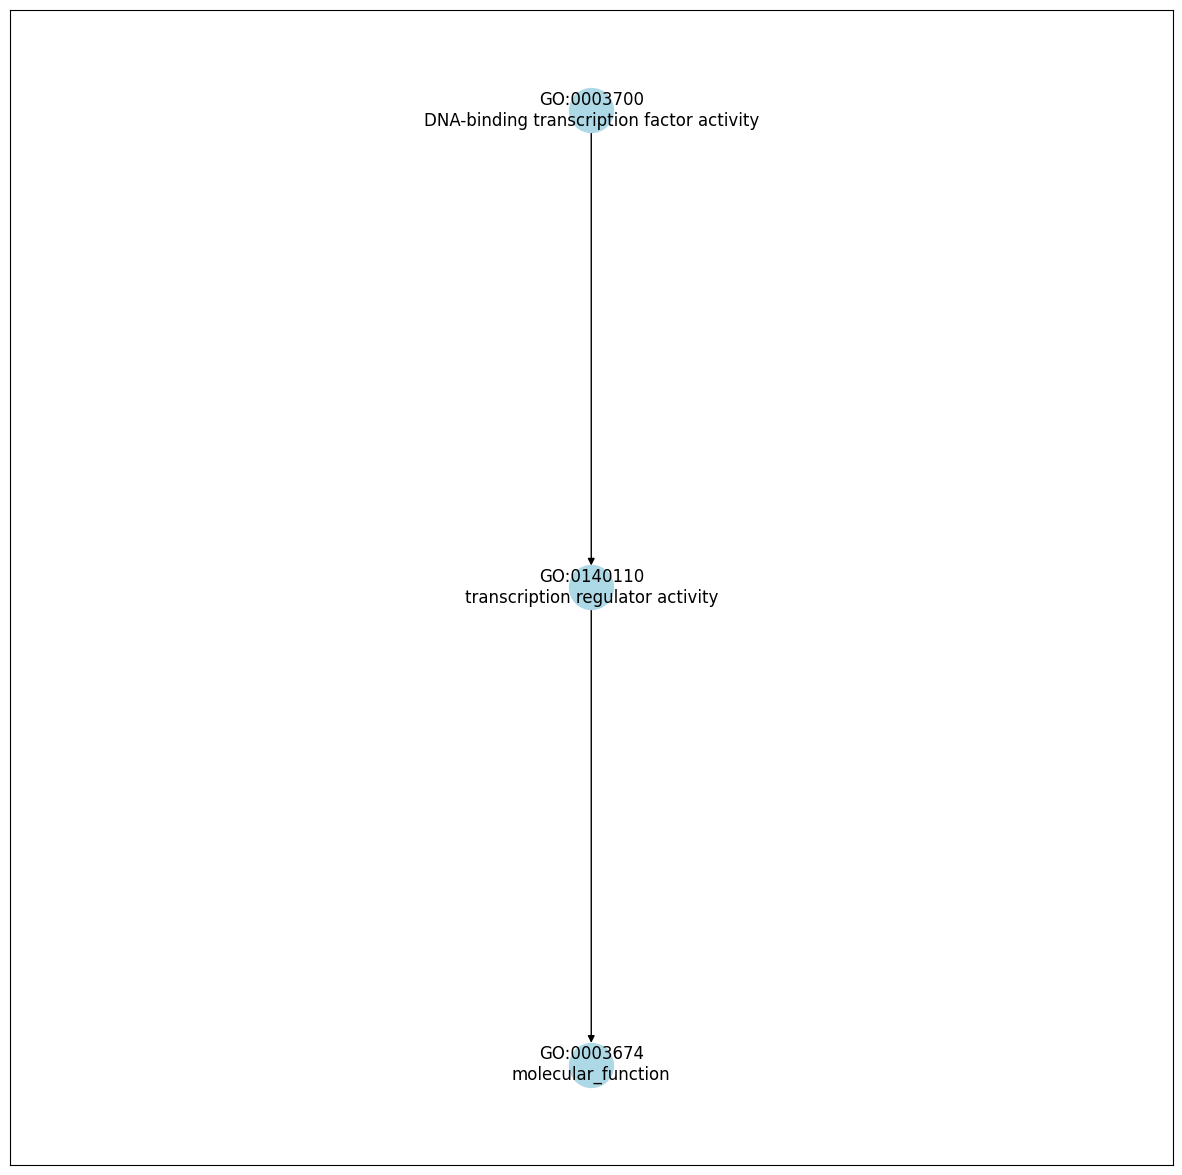

In [14]:
plot_subgraph(knowledge_graph, term, 15, 15)

In [15]:
#This piece of code aims to create a mapping between GO IDs and names in an infographic.
#Bu kod parçası, bir bilgi grafiği içindeki GO ID'ler ile isimler arasında bir eşleme (mapping) oluşturmayı amaçlar.
id_to_name = {id_: data.get('name') for id_, data in knowledge_graph.nodes(data=True)}
# mapping from name to GO ID
# addan GO ID'ye eşleme
name_to_id = {data['name']: id_ for id_, data in knowledge_graph.nodes(data=True) if 'name' in data}

In [16]:
#This snippet demonstrates access to a specific GO ID (GO:0006302) and a name ('double-strand break repair') using the id_to_name and name_to_id dictionaries.
#Bu kod parçası, id_to_name ve name_to_id sözlüklerini kullanarak belirli bir GO ID'ye (GO:0006302) ve bir isme ('double-strand break repair') erişimi göstermektedir.
id_to_name["GO:0006302"], name_to_id['double-strand break repair']

('double-strand break repair', 'GO:0006302')

In [17]:
#This snippet demonstrates access to names corresponding to specific GO IDs using the id_to_name dictionary.
#Bu kod parçası, id_to_name sözlüğünü kullanarak belirli GO ID'lerine karşılık gelen isimlere erişimi göstermektedir.
id_to_name['GO:0008150'], id_to_name['GO:0005575'], id_to_name['GO:0003674']

('biological_process', 'cellular_component', 'molecular_function')

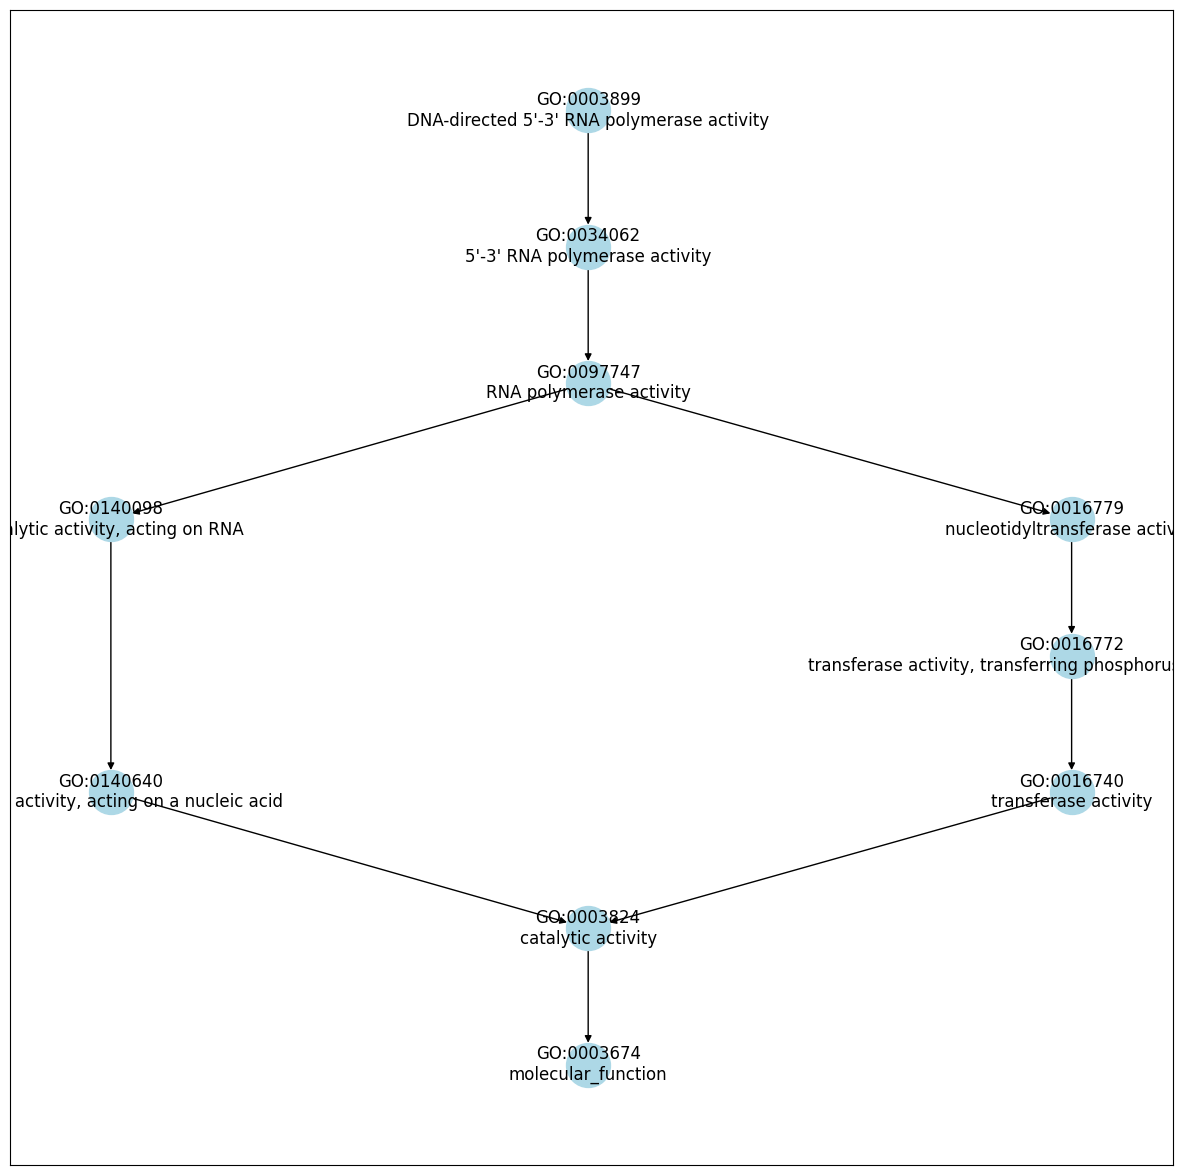

In [18]:
plot_subgraph(knowledge_graph, 'GO:0003899', 15, 15)

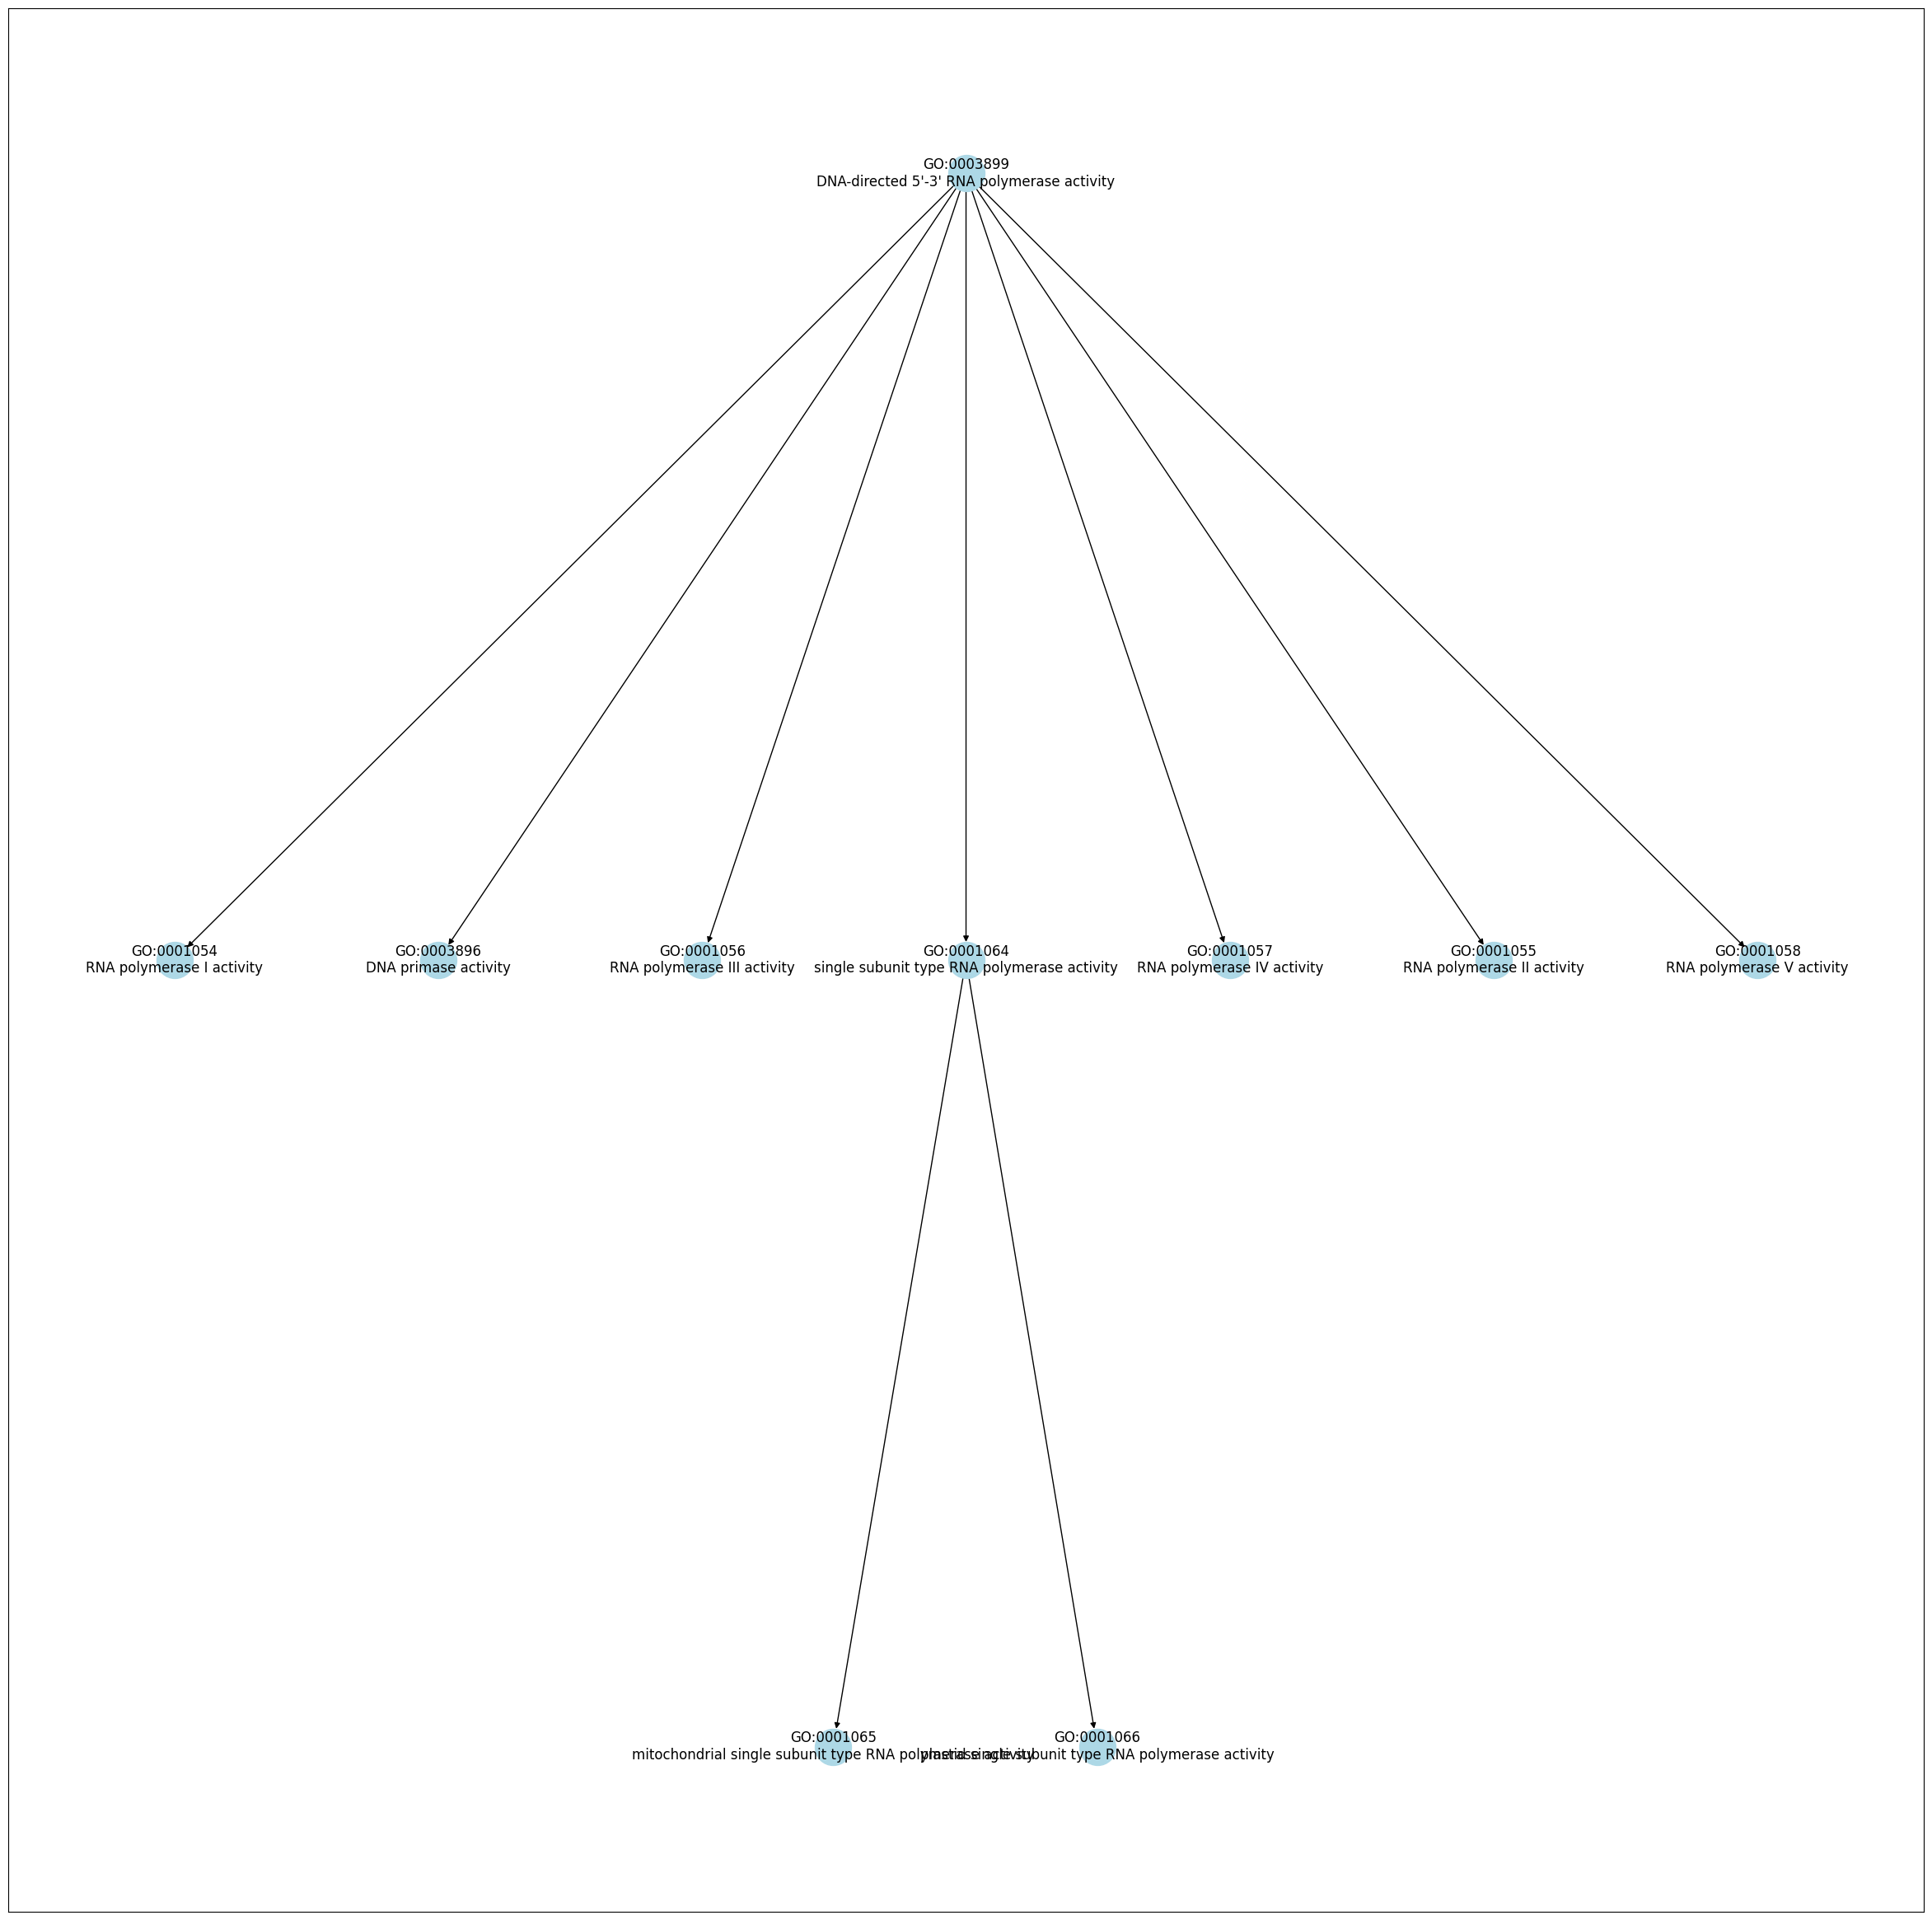

In [ ]:
reversed_graph = knowledge_graph.reverse(copy=True)
# plot the ancestors of GO:0003899
plot_subgraph(reversed_graph, 'GO:0003899', 30, 30)

In [ ]:
#This snippet creates a list named annotations. This list contains specific GO IDs. Related GO IDs are concepts that represent gene functions or biological processes.
#Bu kod parçası, annotations adlı bir liste oluşturur. Bu liste, belirli GO ID'lerini içerir. İlgili GO ID'ler, gen fonksiyonlarını veya biyolojik süreçleri temsil eden kavramlardır.
annotations = [
"GO:0009274",
"GO:0000724",
"GO:0009314",
"GO:0009432",
"GO:0005524",
"GO:0006281",
"GO:0006310",
"GO:0005524",
"GO:0006281",
"GO:0006974",
"GO:0000166"
]

In [ ]:
#This snippet aims to print the corresponding GO ID in the id_to_name dictionary for each GO ID in the annotations list.
#Bu kod parçası, annotations listesindeki her bir GO ID için, ilgili GO ID'nin id_to_name sözlüğündeki karşılığını yazdırmayı amaçlar.
for annotation in annotations:
    print(annotation, id_to_name[annotation])

In [ ]:
#This snippet plots the corresponding subgraph using the plot_subgraph function for each GO ID in the annotations list.
#Bu kod parçası, annotations listesindeki her bir GO ID için plot_subgraph fonksiyonunu kullanarak ilgili alt grafiği çizer.
for annotation in annotations:
    plot_subgraph(knowledge_graph, annotation, 25, 25)

In [ ]:
from Bio import SeqIO
import plotly.graph_objects as go
from collections import Counter

In [ ]:
train_fasta = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta'
test_fasta = '/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta'

In [ ]:
#This piece of code is used to read DNA/RNA/protein sequences (in 'fasta' format) from a training dataset and a test dataset file.
#Bu kod parçası, bir eğitim veri seti ve bir test veri seti dosyasındaki DNA/RNA/protein dizilerini ('fasta' formatında) okumak için kullanılır.
train_sequences = SeqIO.parse(train_fasta, 'fasta')
test_sequences = SeqIO.parse(test_fasta, 'fasta')

In [26]:
#This piece of code reads DNA/RNA/protein sequences (in 'fasta' format) from training and testing dataset files to generate NumPy sequences containing sequence IDs and sequences themselves.
#Bu kod parçası, eğitim ve test veri seti dosyalarındaki DNA/RNA/protein dizilerini ('fasta' formatında) okuyarak dizi kimlikleri ve dizilerin kendilerini içeren NumPy dizileri oluşturur.
train_ids = np.array([seq.id for seq in SeqIO.parse(train_fasta, 'fasta')], dtype=object)
train_sequences = np.array([seq.seq for seq in SeqIO.parse(train_fasta, 'fasta')], dtype=object)
test_ids = np.array([seq.id for seq in SeqIO.parse(test_fasta, 'fasta')], dtype=object)
test_sequences = np.array([seq.seq for seq in SeqIO.parse(test_fasta, 'fasta')], dtype=object)

In [27]:
print('Train fasta file:')
print('Number of ids: ', len(train_ids))
print('Number of sequences: ', len(train_sequences))
print('Number of unique ids: ', len(np.unique(train_ids)))
print('Number of unique sequences: ', len(np.unique(train_sequences)))
print('Test fasta file:')
print('Number of ids: ', len(test_ids))
print('Number of sequences: ', len(test_sequences))
print('Number of unique ids: ', len(np.unique(test_ids)))
print('Number of unique sequences: ', len(np.unique(test_sequences)))

Train fasta file:
Number of ids:  142246
Number of sequences:  142246
Number of unique ids:  142246
Number of unique sequences:  138924
Test fasta file:
Number of ids:  141865
Number of sequences:  141865
Number of unique ids:  141864
Number of unique sequences:  139155


In [28]:
#This piece of code aims to find unique (non-repeating) sequence instances in training and test datasets and return the size of these unique instances.
#Bu kod parçası, eğitim ve test veri setlerindeki benzersiz (tekrarlanmayan) dizi örneklerini bulmayı ve bu benzersiz örneklerin boyutunu döndürmeyi amaçlar.
unique_train_sequences = np.unique(train_sequences)
unique_test_sequences = np.unique(test_sequences)
unique_train_sequences.shape, unique_test_sequences.shape

((138924,), (139155,))

In [ ]:
#This piece of code creates and plots a histogram to visualize the distribution of the lengths of the sequences in the training and test datasets.
#Bu kod parçası, eğitim ve test veri setlerindeki dizilerin uzunluklarının dağılımını görselleştirmek için bir histogram oluşturur ve çizer.
fig = go.Figure()
fig.add_trace(go.Histogram(x=[len(seq) for seq in train_sequences], name='Train', opacity=0.5))
fig.add_trace(go.Histogram(x=[len(seq) for seq in test_sequences], name='Test', opacity=0.5))
fig.update_layout(title='Distribution of sequence lengths in train and test fasta files / Dizi uzunluklarının tren ve test fasta dosyalarındaki dağılımı',
                    xaxis_title='Sequence length / dizi uzunluğu',
                    yaxis_title='Count',
                    bargap=0.2,
                    bargroupgap=0.1)
fig.show()

In [ ]:
#This piece of code creates and plots a histogram to visualize the distribution of the lengths of the sequences in the training and test datasets. It also uses the xaxis_range parameters to constrain the x-range range.
#Bu kod parçası, eğitim ve test veri setlerindeki dizilerin uzunluklarının dağılımını görselleştirmek için bir histogram oluşturur ve çizer. Ayrıca, x ekseni aralığını sınırlamak için xaxis_range parametresi kullanır.
fig = go.Figure()
fig.add_trace(go.Histogram(x=[len(seq) for seq in train_sequences], name='Train', opacity=0.5))
fig.add_trace(go.Histogram(x=[len(seq) for seq in test_sequences], name='Test', opacity=0.5))
fig.update_layout(title='Distribution of sequence lengths in train and test fasta files / Dizi uzunluklarının tren ve test fasta dosyalarındaki dağılımı',
                    xaxis_title='Sequence length / dizi uzunluğu',
                    yaxis_title='Count',
                    bargap=0.2,
                    bargroupgap=0.1,
                    xaxis_range=[0, np.percentile([len(seq) for seq in train_sequences], 95)])
fig.show()


In [ ]:
#This snippet creates a NumPy array by converting arrays from the training and test datasets to the str data type.
#Bu kod parçası, eğitim ve test veri setlerindeki dizileri str veri türüne dönüştürerek bir NumPy dizisi oluşturur.
train_sequences = np.array([str(seq) for seq in train_sequences], dtype=object)
test_sequences = np.array([str(seq) for seq in test_sequences], dtype=object)

In [ ]:
#This piece of code uses the Counter class to calculate the number of amino acids in sequences in the training and test datasets.
#Bu kod parçası, eğitim ve test veri setlerindeki dizilerdeki amino asitlerin sayısını hesaplamak için Counter sınıfını kullanır.
train_aa_counts = Counter(''.join(train_sequences))
test_aa_counts = Counter(''.join(test_sequences))

In [ ]:
#This code snippet rearranges the amino acid numbers in the training and test datasets in order from highest to lowest.
#Bu kod parçası, eğitim ve test veri setlerindeki amino asit sayılarını, en yüksek sayıdan en düşüğe doğru sıralayarak yeniden düzenler.
train_aa_counts = {k: v for k, v in sorted(train_aa_counts.items(), key=lambda item: item[1], reverse=True)}
test_aa_counts = {k: v for k, v in sorted(test_aa_counts.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
#This piece of code creates and plots a bar chart by logging amino acid numbers in the training and test datasets.
#Bu kod parçası, eğitim ve test veri setlerindeki amino asit sayılarını günlüğe kaydederek bir çubuk grafik oluşturur ve çizer.
fig = go.Figure()
fig.add_trace(go.Bar(x=list(train_aa_counts.keys()), y=np.log(list(train_aa_counts.values())), name='Train', opacity=0.5))
fig.add_trace(go.Bar(x=list(test_aa_counts.keys()), y=np.log(list(test_aa_counts.values())), name='Test', opacity=0.5))
fig.update_layout(title='Log counts of amino acids in train and test fasta files / Train ve test fasta dosyalarındaki amino asit sayımlarını günlüğe kaydedin',
                    xaxis_title='Amino acid',
                    yaxis_title='Log count',
                    bargap=0.2,
                    bargroupgap=0.1)
fig.show()

In [ ]:
print('Amino acids in train fasta file: ', train_aa_counts.keys())
# number of amino acids
print('Number of amino acids in train fasta file: ', len(train_aa_counts.keys()))

Amino acids in train fasta file:  dict_keys(['L', 'S', 'A', 'E', 'G', 'V', 'K', 'P', 'T', 'R', 'D', 'I', 'Q', 'N', 'F', 'Y', 'H', 'M', 'C', 'W', 'X', 'U', 'O', 'B', 'Z'])
Number of amino acids in train fasta file:  25


In [ ]:
#The code you provided defines a dictionary called amino_acid_dict that maps single-letter amino acid codes to their corresponding full names. It allows you to easily retrieve the full name of an amino acid by using its single-letter code as a key.
#Sağladığınız kod, tek harfli amino asit kodlarını karşılık gelen tam adlarıyla eşleyen amino_acid_dict adlı bir sözlüğü tanımlar. Tek harfli kodunu anahtar olarak kullanarak bir amino asidin tam adını kolayca almanızı sağlar.
amino_acid_dict = {
    'A': 'Alanine',
    'R': 'Arginine',
    'N': 'Asparagine',
    'D': 'Aspartic Acid',
    'C': 'Cysteine',
    'E': 'Glutamic Acid',
    'Q': 'Glutamine',
    'G': 'Glycine',
    'H': 'Histidine',
    'I': 'Isoleucine',
    'L': 'Leucine',
    'K': 'Lysine',
    'M': 'Methionine',
    'F': 'Phenylalanine',
    'P': 'Proline',
    'S': 'Serine',
    'T': 'Threonine',
    'W': 'Tryptophan',
    'Y': 'Tyrosine',
    'V': 'Valine',
    'X': 'Any/Unknown',
    'O': 'Pyrrolysine',
    'U': 'Selenocysteine',
    'B': 'Asparagine or Aspartic Acid',
    'Z': 'Glutamine or Glutamic Acid',
}

In [ ]:
#The code you provided uses the go module from the plotly library to create a bar chart using the Figure class. The chart compares the log counts of amino acids in the train and test fasta files.
#Sağladığınız kod, Figure sınıfını kullanarak bir çubuk grafik oluşturmak için plotly kitaplığından go modülünü kullanır. Tablo, trende ve test fasta dosyalarındaki amino asitlerin günlük sayılarını karşılaştırır.
fig = go.Figure()
fig.add_trace(go.Bar(x=[amino_acid_dict[aa] for aa in train_aa_counts.keys()], y=np.log(list(train_aa_counts.values())), name='Train', opacity=0.5))
fig.add_trace(go.Bar(x=[amino_acid_dict[aa] for aa in test_aa_counts.keys()], y=np.log(list(test_aa_counts.values())), name='Test', opacity=0.5))
fig.update_layout(title='Log counts of amino acids in train and test fasta files / Train ve test fasta dosyalarındaki amino asit sayımlarını günlüğe kaydedin',
                    xaxis_title='Amino acid',
                    yaxis_title='Log count',
                    bargap=0.2,
                    bargroupgap=0.1)
fig.show()

In [ ]:
!pip install pandas_profiling

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.metrics import AUC
from pandas_profiling import ProfileReport

tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

/tmp/ipykernel_31/2794513014.py:12: DeprecationWarning:

`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.



In [ ]:
testsuperset = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv', sep='\t', encoding='latin-1')
train_terms= pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep='\t', encoding='latin-1')
train_taxonomy=pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv', sep='\t', encoding='latin-1')

In [ ]:
testsuperset_profile = ProfileReport(testsuperset, title="testsuperset")
testsuperset_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train_terms_profile = ProfileReport(train_terms, title="train_terms")
train_terms_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train_taxonomy_profile = ProfileReport(train_taxonomy, title="train_taxonomy")
train_taxonomy_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
DATA_DIR = '/kaggle/input/cafa-5-protein-function-prediction'
MAX_LABELS = 500

### This code defines variables that contain some important information such as the data path and the maximum label count.
### Bu kod, veri yolu ve maksimum etiket sayısı gibi bazı önemli bilgileri içeren değişkenleri tanımlar.

In [ ]:
train_terms = pd.read_csv(os.path.join(DATA_DIR, 'Train', 'train_terms.tsv'), sep='\t')

In [ ]:
terms = train_terms.groupby(['aspect', 'term'])['term'].count().reset_index(name='frequency')
print(terms.groupby('aspect')['term'].nunique())

aspect
BPO    21285
CCO     2957
MFO     7224
Name: term, dtype: int64


### This code calculates the frequency of terms grouped by aspects in a given DataFrame and then provides the number of unique terms for each aspect.
### Bu kod, belirli bir DataFrame'de yönlere göre gruplandırılmış terimlerin sıklığını hesaplar ve ardından her bir özellik için benzersiz terimlerin sayısını sağlar.

In [ ]:
fractions = (terms.groupby('aspect')['term'].nunique() / terms['term'].nunique() * MAX_LABELS).apply(round)
print(fractions)

aspect
BPO    338
CCO     47
MFO    115
Name: term, dtype: int64


### This code calculates the fractions of unique terms for each aspect by dividing the number of unique terms for each aspect by the total number of unique terms in the DataFrame. Then, it multiplies the result by the maximum number of labels (MAX_LABELS) and rounds the values to the nearest integer.
### Bu kod, her özellik için benzersiz terimlerin sayısını DataFrame'deki benzersiz terimlerin toplam sayısına bölerek her bir özellik için benzersiz terimlerin kesirlerini hesaplar. Ardından, sonucu maksimum etiket sayısıyla (MAX_LABELS) çarpar ve değerleri en yakın tamsayıya yuvarlar.

In [ ]:
selected_terms = set()
for aspect, number in fractions.items():
    selection = terms.loc[(terms.aspect == aspect)]
    selection = selection.nlargest(number, columns='frequency', keep='first')
    selected_terms.update(selection.term.to_list())

### This code initializes an empty set called selected_terms. It then iterates over the fractions dictionary, which contains aspects as keys and corresponding fractions as values. For each aspect and its corresponding fraction, the code selects rows from the terms DataFrame where the aspect matches. It then selects the top number rows with the highest frequency based on the 'frequency' column and keeps only the first occurrence if there are ties. The terms from this selection are added to the selected_terms set.
### Bu kod, selected_terms adlı boş bir kümeyi başlatır. Ardından, açıları anahtarlar olarak ve karşılık gelen kesirleri değerler olarak içeren kesirler sözlüğünü yineler. Her özellik ve ona karşılık gelen kesir için kod, yönün eşleştiği DataFrame terimlerinden satırları seçer. Daha sonra 'frekans' sütununa göre en yüksek frekansa sahip en üst sıradaki satırları seçer ve bağlar varsa yalnızca ilk geçtiği yeri tutar. Bu seçimdeki terimler, seçili_terimler kümesine eklenir.

In [ ]:
print(selected_terms)

{'GO:0050789', 'GO:0031324', 'GO:0009617', 'GO:0065003', 'GO:0061061', 'GO:0006468', 'GO:1901363', 'GO:0035295', 'GO:0019752', 'GO:0007276', 'GO:0051241', 'GO:0008324', 'GO:0043168', 'GO:0009056', 'GO:0030695', 'GO:0043227', 'GO:0030030', 'GO:0045595', 'GO:0031090', 'GO:1902494', 'GO:0022857', 'GO:0009967', 'GO:0016788', 'GO:0044271', 'GO:0007281', 'GO:0044249', 'GO:0019900', 'GO:0051254', 'GO:0009536', 'GO:1901565', 'GO:0006950', 'GO:0098542', 'GO:0050790', 'GO:0006974', 'GO:1901700', 'GO:0006259', 'GO:0032504', 'GO:0007017', 'GO:0044237', 'GO:0051716', 'GO:0048878', 'GO:0005634', 'GO:0010604', 'GO:0022008', 'GO:0016757', 'GO:0016301', 'GO:0003723', 'GO:0006793', 'GO:0044877', 'GO:0045935', 'GO:0016791', 'GO:0007389', 'GO:0048858', 'GO:0048729', 'GO:0045892', 'GO:0010648', 'GO:0022607', 'GO:0007409', 'GO:0030097', 'GO:0033365', 'GO:0009987', 'GO:0005654', 'GO:0060429', 'GO:0042330', 'GO:0034641', 'GO:0009653', 'GO:0010033', 'GO:0043604', 'GO:0036094', 'GO:0031982', 'GO:0003824', 'GO:0

In [ ]:
def assign_labels(annotations, selected_terms=selected_terms):
    
    intersection = selected_terms.intersection(annotations)
    labels = np.isin(np.array(list(selected_terms)), np.array(list(intersection)))
    
    return list(labels.astype('int'))



#### This code defines a function named assign_labels that takes an input array called annotations and an optional argument selected_terms.

#### The function performs the following tasks:

1. It finds the intersection between the selected_terms set and the annotations array and stores it in a variable called intersection.
2. It converts the selected_terms set into an array and the intersection set into an array.
3. It checks which elements in the selected_terms array are also present in the intersection array and returns a list of boolean values indicating the presence of each term.
4. Finally, it converts the boolean values to integers and returns the resulting list of labels.

#### Bu kod, ek açıklamalar adı verilen bir giriş dizisini ve isteğe bağlı bir argümanı Selected_terms alan, assign_labels adlı bir işlevi tanımlar.

#### İşlev aşağıdaki görevleri gerçekleştirir:

1. Selected_terms kümesi ile annotations dizisi arasındaki kesişimi bulur ve onu kesişim adı verilen bir değişkende saklar.
2. Selected_terms setini bir diziye ve kesişme setini bir diziye dönüştürür.
3. Selected_terms dizisindeki hangi öğelerin kesişim dizisinde de bulunduğunu kontrol eder ve her terimin varlığını gösteren bir boole değerleri listesi döndürür.
4. Son olarak, boolean değerleri tamsayılara dönüştürür ve sonuçta ortaya çıkan etiket listesini döndürür.

In [ ]:
annotations = train_terms.groupby('EntryID')['term'].apply(set)
labels = annotations.progress_apply(assign_labels)

labels.head()

100%|██████████| 142246/142246 [00:55<00:00, 2582.27it/s]


EntryID
A0A009IHW8    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
A0A021WW32    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
A0A021WZA4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
A0A023FBW4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
A0A023FBW7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: term, dtype: object

### This code calculates labels by grouping a dataframe and returns a preview of the calculated labels.
### Bu kod, bir veri çerçevesini gruplandırarak etiketleri hesaplar ve hesaplanan etiketlerin bir önizlemesini döndürür.

In [ ]:
train_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')

x_train = np.load('/kaggle/input/t5embeds/train_embeds.npy')

In [ ]:
y_train = np.array(labels[train_ids].to_list())

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, shuffle=True, random_state=42)

In [ ]:

# build a simple MLP model in Keras with ReLU activation and nothing else
nfeats = x_train.shape[1]
nlabels = y_train.shape[1]
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=nfeats))
model.add(Dense(128, activation='relu'))
model.add(Dense(nlabels, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[AUC()])


This code builds and compiles a simple MLP (Multi-Layer Perceptron) model using Keras. I can briefly explain their functions:

1. **nfeats** = x_train.shape[1]: This expression assigns the feature in the training dataset to a variable that determines the give and runs as nfeats.

2. **nlabels** = y_train.shape[1]: This expression determines the labeling in the training dataset and assigns it to a Variable variable as nlabels.

3. **model** = Sequential(): This statement creates a sequential Keras model.

4. **model.add(Dense(256, activation='relu', input_dim=nfeats))**: This expression defines a layer of the model. This layer contains 256 neurons, uses the ReLU activation function, and the input size is set in nfeats.

5. **model.add(Dense(128, activation='relu'))**: This expression layers another layer. This layer contains 128 neurons, uses the ReLU activation function.

6. **model.add(Dense(nlabels, activation='sigmoid'))**: This expression defines the boundaries of an output layer. This layer contains nlabels neurons and uses the sigmoid activation function.

7. **model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])**: This expression is the missing values ​​of the model, determining the optimizer and metrics. Binary_crossentropy is used as loss function, man as optimizer and AUC (Curve Under Area) as measurement.

This code defines a simple MLP model with ReLU activation and settings for loss function, optimizer and metrics for training.


Bu kod, Keras kullanarak basit bir MLP (Çok Katmanlı Algılayıcı) modeli oluşturur ve derler. İşlevlerini kısaca açıklayabilirim:

1. **nfeats** = x_train.shape[1]: Bu ifade, eğitim veri setindeki özellik sayısını belirler ve nfeats olarak adlandırılan bir değişkene atar.

2. **nlabels** = y_train.shape[1]: Bu ifade, eğitim veri setindeki etiket sayısını belirler ve nlabels olarak adlandırılan bir değişkene atar.

3. **model** = Sequential(): Bu ifade, ardışık bir Keras modeli oluşturur.

4. **model.add(Dense(256, activation='relu', input_dim=nfeats))**: Bu ifade, modelin bir katmanını tanımlar. Bu katman, 256 nöron içerir, ReLU aktivasyon fonksiyonu kullanır ve giriş boyutu nfeats olarak belirlenir.

5. **model.add(Dense(128, activation='relu'))**: Bu ifade, bir başka katmanı tanımlar. Bu katman, 128 nöron içerir, ReLU aktivasyon fonksiyonu kullanır.

6. **model.add(Dense(nlabels, activation='sigmoid'))**: Bu ifade, bir çıkış katmanını tanımlar. Bu katman, nlabels sayısında nöron içerir ve sigmoid aktivasyon fonksiyonu kullanır.

7. **model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])**: Bu ifade, modelin kayıp fonksiyonunu, optimize ediciyi ve ölçümleri belirler. Kayıp fonksiyonu olarak binary_crossentropy, optimize edici olarak adam ve ölçüm olarak AUC (Alan Altındaki Eğri) kullanılır.

Bu kod, ReLU aktivasyonlu basit bir MLP modeli tanımlar ve eğitim için kayıp fonksiyonu, optimize edici ve ölçümleri ayarlar.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 500)               64500     
                                                                 
Total params: 359,796
Trainable params: 359,796
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/15
834/834 [==============================] - 9s 7ms/step - loss: 0.1561 - auc: 0.8445 - val_loss: 0.1361 - val_auc: 0.8883
Epoch 2/15
834/834 [==============================] - 5s 6ms/step - loss: 0.1327 - auc: 0.8955 - val_loss: 0.1314 - val_auc: 0.8998
Epoch 3/15
834/834 [==============================] - 4s 5ms/step - loss: 0.1290 - auc: 0.9039 - val_loss: 0.1289 - val_auc: 0.9042
Epoch 4/15
834/834 [==============================] - 5s 6ms/step - loss: 0.1265 - auc: 0.9092 - val_loss: 0.1270 - val_auc: 0.9073
Epoch 5/15
834/834 [==============================] - 6s 7ms/step - loss: 0.1246 - auc: 0.9129 - val_loss: 0.1257 - val_auc: 0.9099
Epoch 6/15
834/834 [==============================] - 5s 6ms/step - loss: 0.1230 - auc: 0.9159 - val_loss: 0.1249 - val_auc: 0.9115
Epoch 7/15
834/834 [==============================] - 4s 5ms/step - loss: 0.1216 - auc: 0.9185 - val_loss: 0.1247 - val_auc: 0.9119
Epoch 8/15
834/834 [==============================] - 4s 5ms/step - loss: 0.

In [ ]:
y_hat = model.predict(x_valid)

scores = pd.DataFrame(columns=list(selected_terms), index=['roc_auc'])

1112/1112 [==============================] - 2s 2ms/step


In [ ]:
for i, term in enumerate(selected_terms):
    score = roc_auc_score(y_valid[:, i], y_hat[:, i])
    scores[term] = score

scores.mean(axis=1)

roc_auc    0.8702
dtype: float64

This code calculates ROC AUC (Receiver Operating Characteristics) scores for selected terms. I can briefly explain their functions:

1. **for i, term in enumerate(selected_terms)**: This loop retrieves an index (i) and term (term) pair for each term in the selected_terms array.
 
2. **score = roc_auc_score(y_valid[:, i], y_hat[:, i])**: This expression calculates the ROC AUC score. The expression y_valid[:, i] selects only the column of the tags in the y_valid array that contains the term with index i. The expression y_hat[:, i] selects the column of the predicted labels that contains only the term indexed i. With these selections, the ROC AUC score is calculated and assigned to the score variable.
 
3. **scores[term] = score**: This expression adds the calculated ROC AUC score to a dictionary named scores as the key corresponding to the term term.
 
4. **scores.mean(axis=1)**: This expression calculates the average value of all ROC AUC scores in the scores dictionary and returns an average value for each term.

This code calculates the ROC AUC scores for the selected terms and returns their average value.

Bu kod, seçilen terimler için ROC AUC (Alıcının İşletim Karakteristiği) puanlarını hesaplar. İşlevlerini kısaca açıklayabilirim:

1. **for i, term in enumerate(selected_terms)**: Bu döngü, selected_terms dizisindeki her terim için bir indeks (i) ve terim (term) çiftini alır.
 
2. **score = roc_auc_score(y_valid[:, i], y_hat[:, i])**: Bu ifade, ROC AUC puanını hesaplar. y_valid[:, i] ifadesi, y_valid dizisindeki etiketlerin sadece i indeksli terimi içeren sütununu seçer. y_hat[:, i] ifadesi ise, tahmin edilen etiketlerin sadece i indeksli terimi içeren sütununu seçer. Bu seçimlerle ROC AUC puanı hesaplanır ve score değişkenine atanır.
 
3. **scores[term] = score**: Bu ifade, hesaplanan ROC AUC puanını scores adlı bir sözlüğe term terimine karşılık gelen anahtar olarak ekler.
 
4. **scores.mean(axis=1)**: Bu ifade, scores sözlüğündeki tüm ROC AUC puanlarının ortalama değerini hesaplar ve her terim için bir ortalama değeri döndürür.

Bu kod, seçilen terimler için ROC AUC puanlarını hesaplar ve ortalama değerlerini döndürür.

In [ ]:
test_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
x_test = np.load('/kaggle/input/t5embeds/test_embeds.npy')

In [ ]:
del x_train, y_train, x_valid, y_valid, labels
gc.collect()

27260

In [ ]:
predictions = model.predict(x_test)
del x_test
gc.collect()

4434/4434 [==============================] - 7s 2ms/step


733

In [ ]:
chunk_size = 5_000
chunks = [range(i, min(i + chunk_size, len(predictions))) for i in range(0, len(predictions), chunk_size)]

final_sub = pd.DataFrame()  # Create an empty DataFrame to hold the final result

print(f"processing {len(chunks)} chunks of {chunk_size} predictions each")

processing 29 chunks of 5000 predictions each


This code performs a series of operations and processes the results. I can briefly explain their functions:

1. **chunk_size = 5_000**: This expression assigns a number value to a variable called chunk_size. This determines the size of each piece.

2. **chunks = [range(i, min(i + chunk_size, len(predictions))) for i in range(0, len(predictions), chunk_size)]**: This expression loops through the array of predictions creates. Each chunk contains indices between i and i + chunk_size which is smaller than chunk_size.
 
3. **final_sub = pd.DataFrame()**: This statement creates final_sub, an empty DataFrame to hold the result.

4. **print(f"processing {len(chunks)} chunks of {chunk_size} predictions each")**: This expression prints how many chunks are in the process and the size of each chunk.

This code performs the segmentation operations by doing a series of operations and creates a DataFrame to store the result. It also displays the number and size of parts during the process.

Bu kod, bir dizi işlem gerçekleştirir ve sonuçları işler. İşlevlerini kısaca açıklayabilirim:

1. **chunk_size = 5_000**: Bu ifade, bir sayı değerini chunk_size olarak adlandırılan bir değişkene atar. Bu, her bir parçanın boyutunu belirler.

2. **chunks = [range(i, min(i + chunk_size, len(predictions))) for i in range(0, len(predictions), chunk_size)]**: Bu ifade, predictions dizisi üzerinde döngü oluşturarak parçaları oluşturur. Her bir parça, chunk_size'dan küçük olan i ve i + chunk_size arasındaki indeksleri içerir.
 
3. **final_sub = pd.DataFrame()**: Bu ifade, sonucu tutmak için boş bir DataFrame olan final_sub'ı oluşturur.

4. **print(f"processing {len(chunks)} chunks of {chunk_size} predictions each")**: Bu ifade, işlem sırasında kaç parçanın olduğunu ve her bir parçanın boyutunu yazdırır.

Bu kod, bir dizi işlem yaparak parçalara ayırma işlemlerini gerçekleştirir ve sonucu saklamak için bir DataFrame oluşturur. Ayrıca, işlem sırasında parçaların sayısını ve boyutunu görüntüler.

In [ ]:
for chunk in chunks:
    print(f"processing chunk {chunk}")
    sub = pd.DataFrame(data=predictions[chunk], columns=list(selected_terms), index=test_ids[chunk])
    sub = sub.T.unstack().reset_index(name='prediction')
    sub = sub.loc[sub['prediction'] > 0]
    final_sub = pd.concat([final_sub, sub])  # Concatenate current chunk DataFrame to the final DataFrame

final_sub.head()

processing chunk range(0, 5000)
processing chunk range(5000, 10000)
processing chunk range(10000, 15000)
processing chunk range(15000, 20000)
processing chunk range(20000, 25000)
processing chunk range(25000, 30000)
processing chunk range(30000, 35000)
processing chunk range(35000, 40000)
processing chunk range(40000, 45000)
processing chunk range(45000, 50000)
processing chunk range(50000, 55000)
processing chunk range(55000, 60000)
processing chunk range(60000, 65000)
processing chunk range(65000, 70000)
processing chunk range(70000, 75000)
processing chunk range(75000, 80000)
processing chunk range(80000, 85000)
processing chunk range(85000, 90000)
processing chunk range(90000, 95000)
processing chunk range(95000, 100000)
processing chunk range(100000, 105000)
processing chunk range(105000, 110000)
processing chunk range(110000, 115000)
processing chunk range(115000, 120000)
processing chunk range(120000, 125000)
processing chunk range(125000, 130000)
processing chunk range(130000, 

level_0     level_1  prediction
0  Q9CQV8  GO:0050789    0.456759
1  Q9CQV8  GO:0031324    0.134381
2  Q9CQV8  GO:0009617    0.004639
3  Q9CQV8  GO:0065003    0.012846
4  Q9CQV8  GO:0061061    0.009169

In [ ]:
final_sub.to_csv('submission.tsv', sep='\t', index=False, header=False)

This code processes the results by performing operations on the fragments. I can briefly explain their functions:

1. **for chunk in chunks**: This cycle is repeated for each chunk in the chunks list.

2. **print(f"processing chunk {chunk}")**: This expression prints the index of the processed chunk.

3. **sub = pd.DataFrame(data=predictions[chunk], columns=list(selected_terms), index=test_ids[chunk])**: This expression takes the data from the predictions array based on the fragment indices, the selected_terms list as column names Creates a DataFrame using and using the test_ids array as index.

4. **sub = sub.T.unstack().reset_index(name='prediction')**: This expression returns a DataFrame by transforming the DataFrame, sorting the columns and with a new column name named 'prediction'.

5. **sub = sub.loc[sub['prediction'] > 0]**: This expression selects rows greater than 0 in the 'prediction' column.

6. **final_sub = pd.concat([final_sub, sub])**: This statement merges the current fragment DataFrame with the last DataFrame and updates the final_sub variable.

7. **final_sub.head()**: This statement displays the first few rows of the updated final_sub DataFrame.

This code loops over pieces of data and combines the results to create a DataFrame.

Bu kod, parçalar üzerinde işlemler gerçekleştirerek sonuçları işler. İşlevlerini kısaca açıklayabilirim:

1. **for chunk in chunks**: Bu döngü, chunks listesindeki her bir parça için tekrarlanır.

2. **print(f"processing chunk {chunk}")**: Bu ifade, işlenen parçanın indeksini yazdırır.

3. **sub = pd.DataFrame(data=predictions[chunk], columns=list(selected_terms), index=test_ids[chunk])**: Bu ifade, parça indekslerine dayanarak predictions dizisinden verileri alarak, selected_terms listesini sütun adları olarak kullanarak ve test_ids dizisini indeks olarak kullanarak bir DataFrame oluşturur.

4. **sub = sub.T.unstack().reset_index(name='prediction')**: Bu ifade, DataFrame'i dönüştürerek, sütunları sıralayarak ve 'prediction' adında yeni bir sütun adıyla birlikte bir DataFrame döndürür.

5. **sub = sub.loc[sub['prediction'] > 0]**: Bu ifade, 'prediction' sütununda 0'dan büyük olan satırları seçer.

6. **final_sub = pd.concat([final_sub, sub])**: Bu ifade, mevcut parça DataFrame'ini son DataFrame ile birleştirir ve final_sub değişkenini günceller.

7. **final_sub.head()**: Bu ifade, güncellenen final_sub DataFrame'inin ilk birkaç satırını görüntüler.

Bu kod, veri parçaları üzerinde döngü ile işlemler gerçekleştirir ve sonuçları birleştirerek bir DataFrame oluşturur.